<h1><center>Phân tích tập dữ liệu khuôn mặt thật và giả mạo trên Kaggle</center></h1>

Link bài toán: https://www.kaggle.com/ciplab/real-and-fake-face-detection

In [10]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/School_UIT/Semester IV/[CS114] Machine Learning/Working/CS114.K21.KHTN/Capstone/Fake_Real_Face_Detection

Mounted at /gdrive
/gdrive/My Drive/School_UIT/Semester IV/[CS114] Machine Learning/Working/CS114.K21.KHTN/Capstone/Fake_Real_Face_Detection


In [36]:
import os
from os import listdir
from os.path import isfile, join
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from matplotlib.pyplot import imshow
%matplotlib inline

import cv2

## 1. Một số thông tin cơ bản về tập dữ liệu

- Số lượng dữ liệu là 2041 ảnh, trong đó có 1081 ảnh chứa khuôn mặt người thật và 960 ảnh chứa khuôn mặt giả mạo.
- Tập dữ liệu được thành hai folder là `training_fake` và `training_real`. Folder `training_fake` chứa các ảnh có khuôn mặt giả mạo được phân chia theo độ khó (easy, mid, hard) khi phát hiện khuôn mặt.

In [60]:
PATH = 'dataset/dataset_kaggle/'
TRAINING_FAKE_PATH = PATH +  'training_fake'
TRAINING_REAL_PATH = PATH +  'training_real'
SIZE_DEFAULT = (600, 600)

In [58]:
def load_dataset(path: str, print_info=True):
    """
    + Description: Load dataset containing in `path` directory

    + Require: the `path` must be have format: './dataset/dataset_xx...xxx/training_yyyy/'

    + Return: an array of image objects
    """
    path = os.path.abspath(path)
    try:
        image_files = [f for f in listdir(path) if (isfile(join(path, f)) and (f.endswith('.jpg') or f.endswith('.png') or f.endswith('jpeg')))]
    except:
        print("The path of dataset is not available !")
        exit(-1)
    else:
        dataset = []
        for file in image_files:
            image = mpimg.imread(join(path, file))
            image = cv2.resize(image, SIZE_DEFAULT, interpolation = cv2.INTER_CUBIC)
            dataset.append(image)
        dataset = np.array(dataset)

        if print_info:
            # print some information of dataset:
            print("The number of images is {}".format(len(dataset)))
            print("The size of each image is {}".format(dataset[0].shape))

            # Plot 16 first images in dataset
            for i in range(16):
                plt.subplot(4, 4, i+1)
                imshow(dataset[i])
                if path.endswith('fake'):
                    plt.title("Fake face")
                elif path.endswith('real'):
                    plt.title("Real face")
                else:
                    plt.title("None")
                plt.axis('off')

            plt.show()

        return dataset


The number of images is 960
The size of each image is (600, 600, 3)


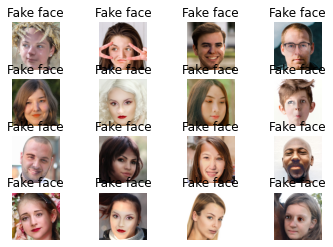

In [5]:
fake_faces = load_dataset(TRAINING_FAKE_PATH, print_info=True)

The number of images is 1081
The size of each image is (600, 600, 3)


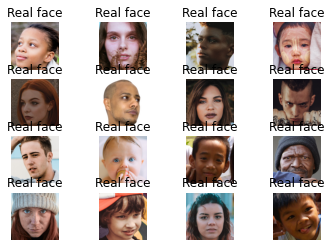

In [6]:
real_faces = load_dataset(TRAINING_REAL_PATH, print_info=True)

**Kết luận:**


*   Tập dữ liệu có tổng cộng 2041 ảnh với kích thước mỗi ảnh là (600, 600 ,3)



## 2. Sử dụng mô hình được xây dựng sẵn

- Link tham khảo: https://www.kaggle.com/martin1234567890/real-vs-fake-face

In [ ]:
!pip install tensorflow
!pip install split-folders

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
import split_folders

In [20]:
# Đường dẫn của tập dữ liệu
dataset_path = "dataset/dataset_kaggle"

In [21]:
# Tăng cường dữ liệu
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                   )

In [22]:
# Load dữ liệu huấn luyện
train = train_datagen.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32)

Found 2041 images belonging to 2 classes.


In [72]:
train.class_indices

{'training_fake': 0, 'training_real': 1}

In [23]:
# Sử dụng MobilenetV2
mobilenetV2 = MobileNetV2(input_shape=(96, 96, 3),
                          include_top=False,
                          weights='imagenet'
                          )

average_layer = GlobalAveragePooling2D()

model = Sequential([
    mobilenetV2,
    average_layer,
    Dense(256, activation=tf.nn.relu),
    BatchNormalization(),
    Dropout(0.2),
    Dense(2, activation=tf.nn.softmax)
])

9412608/9406464 [==============================] - 0s 0us/step


In [24]:
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [26]:
model.fit_generator(train,
                    epochs=50,
                    callbacks=[lr_callbacks])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
64/64 [==============================] - 30s 464ms/step - loss: 1.0205 - accuracy: 0.5835
Epoch 2/50
64/64 [==============================] - 26s 412ms/step - loss: 0.6936 - accuracy: 0.6585
Epoch 3/50
64/64 [==============================] - 27s 421ms/step - loss: 0.5817 - accuracy: 0.7217

In [27]:
model.evaluate_generator(train)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


[0.0019640859682112932, 1.0]

In [28]:
# Save model
model.save("model.h5")

Test thử mô hình

In [ ]:
new_model = tf.keras.models.load_model('model.h5')
new_model.summary()

In [80]:
test_path = 'test_images'
test_images = load_dataset(test_path, print_info=False)

In [81]:
print(test_images.shape)

(12, 600, 600, 3)


In [82]:
print("The prediction is ")
prediction = new_model.predict(test_images)

dictionary = {0: 'Fake', 1: 'Real'}
print(prediction)
for i in range(len(prediction)):
    print("The prediction of test_images {} is {}".format(i, dictionary[np.argmax(prediction[i])]))

The prediction is 
[[5.0943850e-06 9.9999487e-01]
 [1.2655555e-06 9.9999869e-01]
 [3.7516434e-06 9.9999630e-01]
 [2.3475402e-06 9.9999762e-01]
 [1.9382044e-06 9.9999809e-01]
 [3.3901304e-06 9.9999666e-01]
 [9.5983046e-07 9.9999905e-01]
 [2.5580474e-07 9.9999976e-01]
 [4.9276332e-06 9.9999511e-01]
 [3.2166979e-06 9.9999678e-01]
 [1.4978946e-06 9.9999845e-01]
 [1.7405233e-06 9.9999821e-01]]
The prediction of test_images 0 is Real
The prediction of test_images 1 is Real
The prediction of test_images 2 is Real
The prediction of test_images 3 is Real
The prediction of test_images 4 is Real
The prediction of test_images 5 is Real
The prediction of test_images 6 is Real
The prediction of test_images 7 is Real
The prediction of test_images 8 is Real
The prediction of test_images 9 is Real
The prediction of test_images 10 is Real
The prediction of test_images 11 is Real
